<a href="https://colab.research.google.com/github/kellianneyang/project-exploration/blob/main/data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grades Project: Data Cleaning

This notebook continues the work begun in the previous notebook for this project, where all .csv files associated with this dataset were merged.

The goal of this notebook is to prepare data for machine learning preprocessing. We would like to understand the data and understand what we want from the data.

This notebook will:
- Create new columns as necessary (to create new feature variables)
- Delete columns as necessary (to leave out data with high collinearity or high cardinality)
- Separate the data into three dataframes, each with its own target variable (there are multiple possible target variables that we are interested in, and will be applying our machine learning algorithms to them separately)
- Delete any rows from the dataframes that do not have values for the target variable
- Delete any duplicated rows
- Inspect missing values (missing values will NOT be imputed; this will be left for machine learning preprocessing)
- Produce univariate visuals for the target and all feature variables
- Identify outliers

## Overview


To use the data provided in this dataset (https://www.kaggle.com/datasets/Madgrades/uw-madison-courses), which is provided in multiple .csv files, for a machine learning model, we will need to merge the files to create one .csv file.

## .csv files and columns

Included in dataset as separate .csv files:
- schedules.csv: each row is a unique potential schedule
    - (schedule) uuid: unique identifier of schedules
    - start_time: start of class, in minutes
    - end_time: end of class, in minutes (drop -- high co-linearity with start_time)
    - mon: boolean, if class meets on monday
    - tues: "
    - wed: "
    - thurs: "
    - fri: "
    - sat: "
    - sun: "
      - sat and sun have very few values; combine to get more observations
- subjects.csv: each row is a unique subject
    - (subject) code: 3-digit unique identifier of subjects
    - (subject) name: name of subject
    - (subject) abbreviation: abbreviation (e.g. ENGL for English)
- teachings.csv: each row is a unique instructor
    - instructor_id: numeric unique identifier of instructor
    - section_uuid: section taught by instructor
- subject_memberships.csv: each row is a course offering (course offered in certain term; does not encompass all sections in that term)
    - subject_code: subject code associated with course offering
    - course_offering_uuid: unique identifier of course offerings
- sections.csv: each row is a section (specific instance of course at certain time in certain place in certain term)
    - (section) uuid: unique identifier of section (alphanumeric)
      - could have multiple section uuids for cross-listed sections
    - course_offering_uuid: unique identifier of course offering (course offered in certain term but encompasses all sections in that term) 
    - section_type: 3-letter identifier (e.g., LEC for lecture)
    - (section) number: 1-3-number of section (e.g., 301 for section 301)
    - room_uuid: unique identifier of room and building where section is held (including online and off-campus designations)
    - schedule_uuid: unique identifier of schedule for section
- rooms.csv: each row is a specific place
    - (room) uuid: unique identifier of building and room (inclduing off-campus and online)
    - facility_code: unique identifier of building
    - room_code: number of room within a building
- instructors.csv (will not use -- is essentially a duplicate of teachings; can use to look up instructors' names): each row is an instructor
    - (instructor) id: unique identifier of instructor
    - (instructor) name: instructor's name
- grade_distributions.csv: each row is a section's grades
    - course_offering_uuid: identifies the course offering (certain course in certain term, but not broken down into sections)
    - section_number: number of section for grades
    - a_count: number of As
    - ab_count: number of ABs (can be combined with As as needed)
    - b_count: number of Bs
    - bc_count: number of BCs (can be combined with Bs as needed)
    - c_count: number of Cs
    - d_count: number of Ds
    - f_count: number of Fs
    - s_count: satisfactory
    - u_count: unstatisfactory
    - cr_count: credit
    - n_count: no credit
    - p_count
    - i_count: incomplete
    - nw_count: no work
    - nr_count
- course_offerings.csv: each row is a course offering (course offered in certain term)
    - (course offering) uuid: unique identifier of course offering
    - course_uuid: course that the course offering belongs to
    - term_code: academic term when course offering was held
    - (course offering) name: name associate with course offering (can be different than course name)
- courses.csv: each row is a course (abstract; not associated with specific course offering)
    - (course) uuid: uniquely identifies the course
    - (course) name: name of course
    - (course) number: number in course catalog (e.g. 101 for ENGL 101)

## Feature variables

This dataset is large and has many variables we can choose from as our feature variables.

Many of the variables have a large number of unique values (high-cardinality), so we may have to drop those for our machine learning algorithm to be able to predict some variance.

We will also be combining some columns and dropping some columns for various reasons. 

## Target variables

We are interested in whether the feature variables can predict variation in grades. There are many grade types given (see source: https://guide.wisc.edu/undergraduate/#enrollmentandrecordstext), but to keep the problem manageable, we will narrow down the target grades.

We will instantiate three target variables and see if machine learning algorithms can predict the variation in any of them.

1. Proportion of A grades given (of all letter grades given)
2. Proportion of F grades given (of all letter grades given)
3. Average letter grade given (letter grades: A, AB, B, BC, C, D, and F)

# Deleting unnecessary columns and creating new (necessary) ones

In [1]:
# import libraries
import pandas as pd
import seaborn as sns

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# load data
path = '/content/drive/MyDrive/Coding Dojo/Project 2/all_grades_data.csv'
df = pd.read_csv(path, low_memory = False)

In [4]:
# inspect
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162710 entries, 0 to 162709
Data columns (total 44 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            162710 non-null  int64  
 1   section_uuid          162710 non-null  object 
 2   course_offering_uuid  162710 non-null  object 
 3   section_type          162710 non-null  object 
 4   section_number        162710 non-null  float64
 5   room_uuid             66778 non-null   object 
 6   schedule_uuid         162710 non-null  object 
 7   instructor_id         162682 non-null  float64
 8   facility_code         66778 non-null   object 
 9   room_code             64871 non-null   object 
 10  start_time            162710 non-null  float64
 11  end_time              162710 non-null  float64
 12  mon                   162710 non-null  bool   
 13  tues                  162710 non-null  bool   
 14  wed                   162710 non-null  bool   
 15  

In [5]:
# inspect
df.head(10)

,Unnamed: 0,section_uuid,course_offering_uuid,section_type,section_number,room_uuid,schedule_uuid,instructor_id,facility_code,room_code,...,f_count,s_count,u_count,cr_count,n_count,p_count,i_count,nw_count,nr_count,other_count
0,0,214c946a-f56b-365b-a144-1d16049399ed,aa84af10-b176-3fdc-806b-ad7e4d45c93f,fld,1.0,NaN,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,1600463.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1,5dffed06-3e1b-309a-92c9-4b755e20a7e8,a153948c-6fec-3de3-9a6d-3a7210340815,fld,10.0,NaN,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,693634.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2,e3718659-dd65-30d3-987c-6b4092e85d72,a153948c-6fec-3de3-9a6d-3a7210340815,fld,13.0,NaN,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,590599.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,3,24085c2b-1756-320d-971a-a8cf64a78db0,a153948c-6fec-3de3-9a6d-3a7210340815,fld,14.0,NaN,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,664097.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,4,2187b6fd-09fb-3bce-92cf-e86978c295e1,684d5dd7-5964-33ef-81e5-d4070e7b7013,fld,18.0,NaN,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,2600979.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
5,5,812ccf3d-adf8-369c-954a-5beae39db404,684d5dd7-5964-33ef-81e5-d4070e7b7013,fld,13.0,NaN,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,590599.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
6,6,cf401f5b-dc6b-3336-96d9-5ba4bbe049a7,36ab1e06-94ef-363f-841c-0e923bfbdac7,fld,10.0,NaN,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,693634.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
7,7,f98aa8e6-51b7-35f0-b529-0048d4581bf3,36ab1e06-94ef-363f-841c-0e923bfbdac7,fld,14.0,NaN,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,664097.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
8,8,bbe3a638-eebb-380f-9d17-585f6ff37040,aeef8e65-6b2c-3c7a-aeba-3f594b9255df,fld,35.0,NaN,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,4847746.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
9,9,96049783-b9b5-3650-b215-21d4ee5a39d4,aeef8e65-6b2c-3c7a-aeba-3f594b9255df,fld,14.0,NaN,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,664097.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# see list of all columns
df.columns

Index(['Unnamed: 0', 'section_uuid', 'course_offering_uuid', 'section_type',
       'section_number', 'room_uuid', 'schedule_uuid', 'instructor_id',
       'facility_code', 'room_code', 'start_time', 'end_time', 'mon', 'tues',
       'wed', 'thurs', 'fri', 'sat', 'sun', 'subject_code', 'subject_name',
       'subject_abbreviation', 'course_uuid', 'term_code',
       'course_offering_name', 'course_name', 'course_number',
       'course_and_section', 'a_count', 'ab_count', 'b_count', 'bc_count',
       'c_count', 'd_count', 'f_count', 's_count', 'u_count', 'cr_count',
       'n_count', 'p_count', 'i_count', 'nw_count', 'nr_count', 'other_count'],
      dtype='object')

In [7]:
# drop 'Unnamed: 0' (repeat of the index)
df.drop(columns = 'Unnamed: 0',
        inplace = True)

In [8]:
# check
df.columns

Index(['section_uuid', 'course_offering_uuid', 'section_type',
       'section_number', 'room_uuid', 'schedule_uuid', 'instructor_id',
       'facility_code', 'room_code', 'start_time', 'end_time', 'mon', 'tues',
       'wed', 'thurs', 'fri', 'sat', 'sun', 'subject_code', 'subject_name',
       'subject_abbreviation', 'course_uuid', 'term_code',
       'course_offering_name', 'course_name', 'course_number',
       'course_and_section', 'a_count', 'ab_count', 'b_count', 'bc_count',
       'c_count', 'd_count', 'f_count', 's_count', 'u_count', 'cr_count',
       'n_count', 'p_count', 'i_count', 'nw_count', 'nr_count', 'other_count'],
      dtype='object')

## Grades

Our target variables will be 'a_proportion', 'f_proportion', and 'avg_grade'. We will calculate and create these with our existing data and then drop the other grade counts columns.

Information from the University of Wisconsin's website about grades can be found here: https://guide.wisc.edu/undergraduate/#enrollmentandrecordstext

Grades:
- a, ab, b, bc, c, d, f - letter grades
  - ab - intermediate grade between a and b
  - bc - intermediate grade between b and c
- s - satisfactory, used in pass/fail courses
- u - unsatisfactory, used in pass/fail courses
- cr - credit, used in credit/no credit courses
- n - no credit, used in credit/no credit courses
- p - progress: temporary grade used for courses extending beyond one term
- i - incomplete: temporary grade used when work is not completed during a term
- nw - no work: for students who enroll in a course and then never attend
- nr - no report: a grade was not submitted by the instructor
- other - any one of several other grading codes

For a preliminary machine learning attempt with this data, we are interested in predicting any one of the following:
1. the number of As as a proportion of total letter grades
2. the number of Fs as a proportion of total letter grades
3. the average letter grade 

To keep the problem simple, we will only count letter grades given in each course. Although the dataset provides counts for some other grade types (S, U, N, CR, etc.), we are interested in the letter grades given (A, AB, B, BC, C, D, and F). So, we will drop the columns representing other grade types. 

To calculate this number, we will change our dataframe (grades_df) to end up with the following columns:
- course_offering_uuid (unchanged)
- section_number (unchanged)
- a_proportion (number of a grades / number of total grades given per row)
- f_proportion (number of f grades / number of total grades given per row)
- average_grade ((sum of letters * points) / number of total grades given per row); points as follows:
  - a: 4.0
  - ab: 3.5
  - b: 3.0
  - bc: 2.5
  - c: 2.0
  - d: 1.0
  - f: 0.0

In [9]:
# drop following grade counts columns (we are only interested in letter grades at this point):
df.drop(columns = ['s_count', 'u_count', 'cr_count', 'n_count', 'p_count', 'i_count', 'nw_count', 'nr_count', 'other_count'], inplace = True)

In [10]:
# for every row in grades_df:
for i in range(len(df)):

  # assign variable num_a to the 'a_count' value
  num_a = df.at[i, 'a_count']

  # assign variable num_f to the 'f_count' value
  num_f = df.at[i, 'f_count']

  # assign variable num_all_grades to the sum of all letter grade counts
  num_a = df.at[i, 'a_count']
  num_ab = df.at[i, 'ab_count']
  num_b = df.at[i, 'b_count']
  num_bc = df.at[i, 'bc_count']
  num_c = df.at[i, 'c_count']
  num_d = df.at[i, 'd_count']
  num_f = df.at[i, 'f_count']

  num_all_grades = num_a + num_ab + num_b + num_bc + num_c + num_d + num_f

  # create column for num_all_grades to easily be able to delete courses where no grades were recorded
  df.at[i, 'num_all_grades'] = num_all_grades

  # if num_all_grades is not 0 (we want to exclude rows where there are no recorded grades)
  if num_all_grades != 0:

    # calculate the a_proportion & assign to grades_df
    a_proportion = (num_a) / (num_all_grades)
    df.at[i, 'a_proportion'] = a_proportion

    # calculate the f_proportion & assign to grades_df
    f_proportion = (num_f) / (num_all_grades)
    df.at[i, 'f_proportion'] = f_proportion

    # calculate the average grade & assign to grades_df
    avg_grade = ((num_a * 4.0) + (num_ab * 3.5) + (num_b * 3.0) + (num_bc * 2.5) + (num_c * 2.0) + (num_d * 1.0)) / num_all_grades
    df.at[i, 'avg_grade'] = avg_grade


In [11]:
# how to do above action without a for loop?

# this way doesn't prevent divide-by-zero error if there are no grades recorded
# put in if statement?
'''
grades_df['a_proportion] = grades_df['a_count'] / \
                            (grades_df['a_count'] +
                             grades_df['ab_count'] +
                             grades_df['b_count'] +
                             grades_df['bc_count'] +
                             grades_df['c_count'] +
                             grades_df['d_count'] +
                             grades_df['f_count']) if (grades_df['a_count'] +
                                                        grades_df['ab_count'] +
                                                        grades_df['b_count'] +
                                                        grades_df['bc_count'] +
                                                        grades_df['c_count'] +
                                                        grades_df['d_count'] +
                                                        grades_df['f_count']) != 0
'''
'''
grades_df['a_proportion'] = grades_df['a_count'] / \
                            (grades_df['a_count'] +
                             grades_df['ab_count'] +
                             grades_df['b_count'] +
                             grades_df['bc_count'] +
                             grades_df['c_count'] +
                             grades_df['d_count'] +
                             grades_df['f_count'])

grades_df['f_proportion'] = grades_df['f_count'] / \
                            (grades_df['a_count'] +
                             grades_df['ab_count'] +
                             grades_df['b_count'] +
                             grades_df['bc_count'] +
                             grades_df['c_count'] +
                             grades_df['d_count'] +
                             grades_df['f_count'])

grades_df['avg_grade'] = ( (grades_df['a_count'] * 4.0) +
                           (grades_df['ab_count'] * 3.5) +
                           (grades_df['b_count'] * 3.0) +
                           (grades_df['bc_count'] * 2.5) +
                           (grades_df['c_count'] * 2.0) +
                           (grades_df['d_count'] * 1.0) +
                           (grades_df['f_count'] * 0.0) ) / \
                         (  grades_df['a_count'] +
                            grades_df['ab_count'] +
                            grades_df['b_count'] +
                            grades_df['bc_count'] +
                            grades_df['c_count'] +
                            grades_df['d_count'] +
                            grades_df['f_count'] )
'''

"\ngrades_df['a_proportion'] = grades_df['a_count'] /                             (grades_df['a_count'] +\n                             grades_df['ab_count'] +\n                             grades_df['b_count'] +\n                             grades_df['bc_count'] +\n                             grades_df['c_count'] +\n                             grades_df['d_count'] +\n                             grades_df['f_count'])\n\ngrades_df['f_proportion'] = grades_df['f_count'] /                             (grades_df['a_count'] +\n                             grades_df['ab_count'] +\n                             grades_df['b_count'] +\n                             grades_df['bc_count'] +\n                             grades_df['c_count'] +\n                             grades_df['d_count'] +\n                             grades_df['f_count'])\n\ngrades_df['avg_grade'] = ( (grades_df['a_count'] * 4.0) +\n                           (grades_df['ab_count'] * 3.5) +\n                           (

In [12]:
# check
df.columns

Index(['section_uuid', 'course_offering_uuid', 'section_type',
       'section_number', 'room_uuid', 'schedule_uuid', 'instructor_id',
       'facility_code', 'room_code', 'start_time', 'end_time', 'mon', 'tues',
       'wed', 'thurs', 'fri', 'sat', 'sun', 'subject_code', 'subject_name',
       'subject_abbreviation', 'course_uuid', 'term_code',
       'course_offering_name', 'course_name', 'course_number',
       'course_and_section', 'a_count', 'ab_count', 'b_count', 'bc_count',
       'c_count', 'd_count', 'f_count', 'num_all_grades', 'a_proportion',
       'f_proportion', 'avg_grade'],
      dtype='object')

In [13]:
# check
df[['a_proportion', 'f_proportion', 'avg_grade']].sample(10)

,a_proportion,f_proportion,avg_grade
151926,0.500000,0.000000,3.333333
96017,NaN,NaN,NaN
105814,0.583333,0.000000,3.791667
41672,NaN,NaN,NaN
51252,NaN,NaN,NaN
26890,NaN,NaN,NaN
62644,NaN,NaN,NaN
37094,0.352941,0.000000,3.441176
139442,0.333333,0.047619,3.285714
24731,NaN,NaN,NaN


In [14]:
# drop rest of grades columns
df.drop(columns = ['a_count', 'ab_count', 'b_count', 'bc_count', 'c_count', 
                   'd_count', 'f_count', 'num_all_grades'],
        inplace = True)

In [15]:
# check
df.columns

Index(['section_uuid', 'course_offering_uuid', 'section_type',
       'section_number', 'room_uuid', 'schedule_uuid', 'instructor_id',
       'facility_code', 'room_code', 'start_time', 'end_time', 'mon', 'tues',
       'wed', 'thurs', 'fri', 'sat', 'sun', 'subject_code', 'subject_name',
       'subject_abbreviation', 'course_uuid', 'term_code',
       'course_offering_name', 'course_name', 'course_number',
       'course_and_section', 'a_proportion', 'f_proportion', 'avg_grade'],
      dtype='object')

In [16]:
# delete rows that don't have any values for any of the three target
# variable columns
df.dropna(subset = ['a_proportion', 'f_proportion', 'avg_grade'], 
          how = 'all', 
          inplace = True)

In [17]:
# check
df.shape

(64186, 30)

## 'term_code'

The current 'term_code' column gives a 4-digit code indicating the term the course was offered in. 

'term_code':
- first digit always 1 (21st century)
- second two digits academic year (from 07 to 18; year that the academic year ends in summer)
- fourth digit term (2 = fall, 4 = spring, 6 = summer)

Source: https://kb.wisc.edu/registrar/117776

In [18]:
df.reset_index(inplace = True, drop = True)

In [19]:
# inspect
df['term_code'].value_counts(dropna = False)
# data includes years '07' to '18' and only fall (2) and spring (4) terms

1072.0    3141
1082.0    3055
1092.0    3047
1102.0    3042
1074.0    3006
1152.0    3001
1122.0    2966
1132.0    2946
1112.0    2939
1142.0    2925
1084.0    2921
1162.0    2901
1172.0    2891
1104.0    2869
1094.0    2864
1134.0    2845
1182.0    2832
1114.0    2828
1144.0    2816
1154.0    2810
1164.0    2776
1174.0    2765
Name: term_code, dtype: int64

We will split 'term_code' into one column for year (numeric, 7-18) and one for term (nominal, fall or spring)

In [20]:
# iterate through all rows in df
for i in range(len(df)):

  # create string of 'term_code' for indexing
  string = df.at[i, 'term_code'].astype(str)

  # make sure string is 4 or more characters long
  if len(string) >= 4:

    # assign 'year' as the middle two characters in the string
    df.at[i, 'year'] = string[1:3]

    # if string ends in 2
    if string[3] == '2':

      # assign 'term' as 'fall'
      df.at[i, 'term'] = 'fall'
  
    # else
    else:

      # assign 'term' as 'spring'
      df.at[i, 'term'] = 'spring'

In [21]:
# how to do above actions without a for loop?
# this doesn't work

# df['year'] = df['term_code'].astype(str)[1:3]
# df['term'] = df['term_code'].astype(str)[3]

In [22]:
# check
print(df['year'].value_counts(dropna = False))
print(df['term'].value_counts(dropna = False))

07    6147
08    5976
10    5911
09    5911
15    5811
13    5791
11    5767
14    5741
16    5677
17    5656
12    2966
18    2832
Name: year, dtype: int64
fall      35686
spring    28500
Name: term, dtype: int64


In [23]:
# drop 'term_code' as it is now redundant
df.drop(columns = 'term_code', inplace = True)

In [24]:
# check
df.columns

Index(['section_uuid', 'course_offering_uuid', 'section_type',
       'section_number', 'room_uuid', 'schedule_uuid', 'instructor_id',
       'facility_code', 'room_code', 'start_time', 'end_time', 'mon', 'tues',
       'wed', 'thurs', 'fri', 'sat', 'sun', 'subject_code', 'subject_name',
       'subject_abbreviation', 'course_uuid', 'course_offering_name',
       'course_name', 'course_number', 'course_and_section', 'a_proportion',
       'f_proportion', 'avg_grade', 'year', 'term'],
      dtype='object')

## Rooms and buildings

Every room_uuid has a facility_code which indicates a building, and a room_code which indicates a room in the building. We will drop the room_code column because it is likely a high-cardinality variable, since there are many, many rooms on campus. We will keep the building (facility_code). 

In [25]:
# pd.set_option('display.max_rows', None)

In [26]:
df.drop(columns = ['room_uuid', 'room_code'], inplace = True)

In [27]:
# check
df.columns

Index(['section_uuid', 'course_offering_uuid', 'section_type',
       'section_number', 'schedule_uuid', 'instructor_id', 'facility_code',
       'start_time', 'end_time', 'mon', 'tues', 'wed', 'thurs', 'fri', 'sat',
       'sun', 'subject_code', 'subject_name', 'subject_abbreviation',
       'course_uuid', 'course_offering_name', 'course_name', 'course_number',
       'course_and_section', 'a_proportion', 'f_proportion', 'avg_grade',
       'year', 'term'],
      dtype='object')

## Schedules

'start_time' and 'end_time' will probably have a high degree of co-linearity due to many classes being on a fixed schedule. So, we can drop 'end_time'. 

But, we are interested in if the length of a class may explain some variance in the grades earned, so first we will calculate 'class_length'. 'class_length' will represent the length of the class in minutes on any day of the week that the class meets (if class meets from 9:00am to 9:50am on MWF, 'class_length' will be 50 minutes)). 

We are also interested in if the total contact time (per week) may explain some variance. So we will calculate 'total_time', which will be the 'class_length' multiplied by the number of classes per week (so if class meets from 9:00am to 9:50am on MWF, 'total_time' will be 150 minutes). 

In [28]:
# 'class_length'
df['class_length'] = df['end_time'] - df['start_time']

In [29]:
df.reset_index(inplace = True, drop = True)

In [30]:
df.dtypes

section_uuid             object
course_offering_uuid     object
section_type             object
section_number          float64
schedule_uuid            object
instructor_id           float64
facility_code            object
start_time              float64
end_time                float64
mon                        bool
tues                       bool
wed                        bool
thurs                      bool
fri                        bool
sat                        bool
sun                        bool
subject_code              int64
subject_name             object
subject_abbreviation     object
course_uuid              object
course_offering_name     object
course_name              object
course_number           float64
course_and_section       object
a_proportion            float64
f_proportion            float64
avg_grade               float64
year                     object
term                     object
class_length            float64
dtype: object

In [31]:
# in order to calculate total_time, we will need to convert the boolean columns 
# into object columns
for day in ['mon', 'tues', 'wed', 'thurs', 'fri', 'sat', 'sun']:
  df[day] = df[day].astype(object)

In [32]:
# check
df.dtypes

section_uuid             object
course_offering_uuid     object
section_type             object
section_number          float64
schedule_uuid            object
instructor_id           float64
facility_code            object
start_time              float64
end_time                float64
mon                      object
tues                     object
wed                      object
thurs                    object
fri                      object
sat                      object
sun                      object
subject_code              int64
subject_name             object
subject_abbreviation     object
course_uuid              object
course_offering_name     object
course_name              object
course_number           float64
course_and_section       object
a_proportion            float64
f_proportion            float64
avg_grade               float64
year                     object
term                     object
class_length            float64
dtype: object

In [33]:
# 'total_time'
df['total_time'] = df['class_length'] * (df['mon'] + df['tues'] + df['wed'] + df['thurs'] + df['fri'] + df['sat'] + df['sun'])

In [34]:
# check
df[['total_time', 'class_length']]

,total_time,class_length
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
64181,150.0,50.0
64182,150.0,50.0
64183,150.0,50.0
64184,150.0,50.0


In [35]:
# check
df['total_time'] = df['total_time'].astype(int)

Check value_counts for days of the week

In [36]:
for day in ['mon', 'tues', 'wed', 'thurs', 'fri', 'sat', 'sun']:
  print(df[day].value_counts())

False    36546
True     27640
Name: mon, dtype: int64
False    36954
True     27232
Name: tues, dtype: int64
False    37056
True     27130
Name: wed, dtype: int64
False    38275
True     25911
Name: thurs, dtype: int64
False    48729
True     15457
Name: fri, dtype: int64
False    62543
True      1643
Name: sat, dtype: int64
False    64121
True        65
Name: sun, dtype: int64


Combine classes that meet on weekends into one category to increase number of counts.

In [37]:
df['mon'].dtype

dtype('O')

In [38]:
# how to make this section of code fewer lines (with an or statement?)

for i in range(len(df)):
  if df.at[i, 'sat'] == True:
    df.at[i, 'weekend'] = 'True'
  elif df.at[i, 'sun'] == True:
    df.at[i, 'weekend'] = 'True'
  else:
    df.at[i, 'weekend'] = 'False'

In [39]:
'''
# how to do above without a for loop?

if df['sat'] == True:
  df['weekend'] = True
elif df['sun'] == True:
  df['weekend'] = True
else:
  df['weekend'] = False
'''

"\n# how to do above without a for loop?\n\nif df['sat'] == True:\n  df['weekend'] = True\nelif df['sun'] == True:\n  df['weekend'] = True\nelse:\n  df['weekend'] = False\n"

In [40]:
# check
df['weekend'].value_counts()

False    62503
True      1683
Name: weekend, dtype: int64

In [41]:
# delete 'sat' and 'sun' classes (highly correlated with 'weekend'), and
# 'end_time' (highly correlated with 'start_time' and 'class_length')
df.drop(columns = ['sat', 'sun', 'end_time'], inplace = True)

In [42]:
# check
df.columns

Index(['section_uuid', 'course_offering_uuid', 'section_type',
       'section_number', 'schedule_uuid', 'instructor_id', 'facility_code',
       'start_time', 'mon', 'tues', 'wed', 'thurs', 'fri', 'subject_code',
       'subject_name', 'subject_abbreviation', 'course_uuid',
       'course_offering_name', 'course_name', 'course_number',
       'course_and_section', 'a_proportion', 'f_proportion', 'avg_grade',
       'year', 'term', 'class_length', 'total_time', 'weekend'],
      dtype='object')

In [43]:
# drop 'schedule_uuid'; it correlates with the other schedule variables
df.drop(columns = 'schedule_uuid', inplace = True)

In [44]:
# check
df.columns

Index(['section_uuid', 'course_offering_uuid', 'section_type',
       'section_number', 'instructor_id', 'facility_code', 'start_time', 'mon',
       'tues', 'wed', 'thurs', 'fri', 'subject_code', 'subject_name',
       'subject_abbreviation', 'course_uuid', 'course_offering_name',
       'course_name', 'course_number', 'course_and_section', 'a_proportion',
       'f_proportion', 'avg_grade', 'year', 'term', 'class_length',
       'total_time', 'weekend'],
      dtype='object')

## Subjects

Delete 'subject_abbreviations' and 'subject_codes', as these are repeats of the 'subject_name' column.

In [45]:
df.drop(columns = ['subject_code', 'subject_abbreviation'], inplace = True)

In [46]:
# check
df.columns

Index(['section_uuid', 'course_offering_uuid', 'section_type',
       'section_number', 'instructor_id', 'facility_code', 'start_time', 'mon',
       'tues', 'wed', 'thurs', 'fri', 'subject_name', 'course_uuid',
       'course_offering_name', 'course_name', 'course_number',
       'course_and_section', 'a_proportion', 'f_proportion', 'avg_grade',
       'year', 'term', 'class_length', 'total_time', 'weekend'],
      dtype='object')

## Course number

In [47]:
df['course_number'].describe()

count    64186.000000
mean       446.496713
std        258.355618
min          1.000000
25%        223.000000
50%        400.000000
75%        676.000000
max        999.000000
Name: course_number, dtype: float64

The 'course_number' column includes numbers in the following ranges:
- below 100: below college-level
- 100-299: elementary (undergraduate students only)
- 300-499: intermediate (grad & undergrad)
- 500-699: advanced (grad & undergrad)
- 700+: graduate students only

Source: https://grad.wisc.edu/documents/course-numbering-system/

We will split up the courses into these ranges to reduce the cardinality of the variable.

We will drop the below college-level and graduate student only courses and retain just courses that are elementary, intermediate, or advanced, and that undergraduate students may take. (But we will wait until after merging with big_df to do so, so that we delete the other information for these courses as well.)

In [48]:
for i in range(len(df)):
  if df.at[i, 'course_number'] < 100:
    df.at[i, 'course_difficulty'] = 'below level'
  elif df.at[i, 'course_number'] < 300:
    df.at[i, 'course_difficulty'] = 'elementary'
  elif df.at[i, 'course_number'] < 500:
    df.at[i, 'course_difficulty'] = 'intermediate'
  elif df.at[i, 'course_number'] < 700:
    df.at[i, 'course_difficulty'] = 'advanced'
  elif df.at[i, 'course_number'] >= 700:
    df.at[i, 'course_difficulty'] = 'grad level'

In [49]:
# how to do above action without a for loop?
# courses_df['course_difficulty'] = 'below level' if courses_df['course_difficulty] < 100 else pass
# courses_df['course_difficulty'] = 'elementary' if courses_df['course_difficulty] < 300 else pass
# courses_df['course_difficulty'] = 'intermediate' if courses_df['course_difficulty] < 500 else pass
# courses_df['course_difficulty'] = 'advanced' if courses_df['course_difficulty] < 700 else pass
# courses_df['course_difficulty'] = 'grad level' if courses_df['course_difficulty] >= 700 else pass

In [50]:
# check
df['course_difficulty'].value_counts()

elementary      19562
intermediate    18574
grad level      14130
advanced        11355
below level       565
Name: course_difficulty, dtype: int64

In [51]:
# we are only interested in 'elementary', 'intermediate', and 'advanced' courses
df.drop(df[(df['course_difficulty'] == 'below level') | 
           (df['course_difficulty'] == 'grad level')].index, 
        inplace = True)


In [52]:
# check
df['course_difficulty'].value_counts()

elementary      19562
intermediate    18574
advanced        11355
Name: course_difficulty, dtype: int64

In [53]:
# drop course_number column
df.drop(columns = 'course_number', inplace = True)

In [54]:
# check
df.columns

Index(['section_uuid', 'course_offering_uuid', 'section_type',
       'section_number', 'instructor_id', 'facility_code', 'start_time', 'mon',
       'tues', 'wed', 'thurs', 'fri', 'subject_name', 'course_uuid',
       'course_offering_name', 'course_name', 'course_and_section',
       'a_proportion', 'f_proportion', 'avg_grade', 'year', 'term',
       'class_length', 'total_time', 'weekend', 'course_difficulty'],
      dtype='object')

## course_uuid

In [55]:
# can drop 'course_uuid' column because it should match up with 'course_name' column
df.drop(columns = 'course_uuid', inplace = True)

In [56]:
# check
df.columns

Index(['section_uuid', 'course_offering_uuid', 'section_type',
       'section_number', 'instructor_id', 'facility_code', 'start_time', 'mon',
       'tues', 'wed', 'thurs', 'fri', 'subject_name', 'course_offering_name',
       'course_name', 'course_and_section', 'a_proportion', 'f_proportion',
       'avg_grade', 'year', 'term', 'class_length', 'total_time', 'weekend',
       'course_difficulty'],
      dtype='object')

### Reduce cardinality in instructor_id (binning):
- Group instructors who have taught less than 20 sections into one group.

In [57]:
print(len(df['instructor_id']))
print(len(df))

49491
49491


In [58]:
print(df['instructor_id'].value_counts())

566960.0     132
496397.0     106
2601912.0     89
2601706.0     85
319547.0      81
            ... 
4716883.0      1
4721762.0      1
3375280.0      1
3457484.0      1
900462.0       1
Name: instructor_id, Length: 7106, dtype: int64


In [59]:
# create empty list to store instructor_ids
instructor_20_list = []

# iterate over values and counts in 'instructor_id'
for value, count in df['instructor_id'].value_counts().items():
  
  # if count is more than 20 (i.e. instructor taught more than 20 sections)
  if count > 20:
    
    # append to list
    instructor_20_list.append(value)

# this is the number of instructor_ids who taught more than 20 sections
print(len(instructor_20_list))
print(type(instructor_20_list))
print(instructor_20_list[:20])

521
<class 'list'>
[566960.0, 496397.0, 2601912.0, 2601706.0, 319547.0, 157057.0, 663146.0, 783847.0, 2601527.0, 623858.0, 4232086.0, 309711.0, 464468.0, 1005245.0, 980056.0, 3013497.0, 412406.0, 3615604.0, 3216300.0, 2601502.0]


In [60]:
# assign new column where 'instructor_id' is copied if instructor taught more
# than 20 sections, and where 'other' if not

df.loc[~df['instructor_id'].isin(instructor_20_list), 'instructor_id'] = 'other'

In [61]:
# check
df['instructor_id'].sample(10)

40799        other
7176     3574850.0
56102        other
38478     912304.0
14285    3368498.0
14903        other
33122    2601762.0
17955     818841.0
24565        other
1075         other
Name: instructor_id, dtype: object

In [62]:
# how many unique values now in 'instructor_id_250?
df['instructor_id'].nunique()

# this can be played with later to see if higher cardinality will help the model

522

### Reduce cardinality in course_name (binning):

In [63]:
# how many unique values are in 'course_name'?
df['course_name'].nunique()

3771

In [64]:
# look at value_counts
df['course_name'].value_counts()

introduction to speech composition                                               997
special topics                                                                   705
freshman composition                                                             652
third semester spanish                                                           463
intermediate language practice with emphasis on writing and grammar              459
                                                                                ... 
contemporary skill set literature in french                                        1
elementary student teaching seminar - elementary/special education dual major      1
seminar in electrical and computer engineering                                     1
the history of evolutionary thought                                                1
soccer ii                                                                          1
Name: course_name, Length: 3771, dtype: int64

In [65]:
# create empty list to store course_names
course_name_20_list = []

# iterate over values and counts in 'course_name'
for value, count in df['course_name'].value_counts().items():
  
  # if count is more than 20 (i.e. course has been taught more than 50 times)
  if count > 20:
    
    # append to list
    course_name_20_list.append(value)

# this is the number of courses that have been taught more than 20 times
print(len(course_name_20_list))

521


In [66]:
# assign new column where 'course_name' is copied if course was taught more
# than 20 times, and where 'other' if not
df.loc[~df['course_name'].isin(course_name_20_list), 'course_name'] = 'other'

In [67]:
# check
df['course_name'].sample(10)

54534                             introduction to painting
54160                                            drawing i
1882                                        ensemble-brass
27186                                                other
19182                           topics in hispanic culture
44195       advanced laboratory techniques in microbiology
25075              introduction to international relations
25435                            topics-finite mathematics
15166                             strategic media planning
20992    human resources development: educational effec...
Name: course_name, dtype: object

In [68]:
# how many unique values now in 'course_name'?
df['course_name'].nunique()

# this can be played with later to see if higher cardinality will help the model

522

### Drop course_offering_name and course_offering_uuid

In [69]:
# course_offering_name may be correlated with course_name, so we will drop it for now
# course_offering_uuid will not predict grades, so we will drop it for now
df.drop(columns = ['course_offering_name', 'course_offering_uuid'], inplace = True)

In [70]:
# check
df.columns

Index(['section_uuid', 'section_type', 'section_number', 'instructor_id',
       'facility_code', 'start_time', 'mon', 'tues', 'wed', 'thurs', 'fri',
       'subject_name', 'course_name', 'course_and_section', 'a_proportion',
       'f_proportion', 'avg_grade', 'year', 'term', 'class_length',
       'total_time', 'weekend', 'course_difficulty'],
      dtype='object')

### section_uuid, section_number

In [71]:
#drop section_uuid, section_number, and grades_section_number because
# they will not be predictive of grades
df.drop(columns = ['section_uuid', 'section_number'], inplace = True)

In [72]:
# check
df.columns

Index(['section_type', 'instructor_id', 'facility_code', 'start_time', 'mon',
       'tues', 'wed', 'thurs', 'fri', 'subject_name', 'course_name',
       'course_and_section', 'a_proportion', 'f_proportion', 'avg_grade',
       'year', 'term', 'class_length', 'total_time', 'weekend',
       'course_difficulty'],
      dtype='object')

## Final checks

In [73]:
# check unique values and value_counts()
for col in df.columns:
  print(f"{col}:")
  print(f"unique values: {df[col].nunique()}")
  print(f"value counts: \n{df[col].value_counts(dropna = False)}")
  print()

section_type:
unique values: 6
value counts: 
lec    39207
lab     4810
sem     2570
ind     2113
fld      549
dis      242
Name: section_type, dtype: int64

instructor_id:
unique values: 522
value counts: 
other        32772
566960.0       132
496397.0       106
2601912.0       89
2601706.0       85
             ...  
537957.0        21
475025.0        21
367808.0        21
172570.0        21
4131298.0       21
Name: instructor_id, Length: 522, dtype: int64

facility_code:
unique values: 119
value counts: 
0482     7447
0469     4561
NaN      3837
0140     3446
0408     2532
         ... 
0039        1
0084b       1
0033        1
1400g       1
1400e       1
Name: facility_code, Length: 120, dtype: int64

start_time:
unique values: 118
value counts: 
 660.0     7599
 800.0     4392
 595.0     4315
-1.0       3976
 870.0     3628
           ... 
 925.0        1
 665.0        1
 1055.0       1
 1040.0       1
 550.0        1
Name: start_time, Length: 118, dtype: int64

mon:
unique values

In [74]:
# course_and_section is uniquely identifying each row, so it can be dropped
df.drop(columns = 'course_and_section', inplace = True)

In [75]:
# check cardinality
for col in df.columns:
  print(col)
  print(df[col].nunique())
  print()

# except for the target variables, all of the columns have a number of unique values less than 450

section_type
6

instructor_id
522

facility_code
119

start_time
118

mon
2

tues
2

wed
2

thurs
2

fri
2

subject_name
180

course_name
522

a_proportion
4137

f_proportion
1308

avg_grade
6955

year
12

term
2

class_length
61

total_time
90

weekend
2

course_difficulty
3



In [76]:
df.reset_index(drop = True)

,section_type,instructor_id,facility_code,start_time,mon,tues,wed,thurs,fri,subject_name,course_name,a_proportion,f_proportion,avg_grade,year,term,class_length,total_time,weekend,course_difficulty
0,lec,other,NaN,-1.0,False,False,False,False,False,communication arts,introduction to speech composition,0.250000,0.000000,3.625000,15,spring,0.0,0,False,elementary
1,lec,other,0545,660.0,False,True,False,True,False,communication arts,introduction to speech composition,0.230769,0.000000,3.346154,15,spring,75.0,150,False,elementary
2,lec,other,0545,660.0,False,True,False,True,False,communication arts,introduction to speech composition,0.153846,0.000000,3.500000,15,spring,75.0,150,False,elementary
3,lec,other,0545,595.0,True,False,True,False,True,communication arts,introduction to speech composition,0.500000,0.000000,3.750000,15,spring,50.0,150,False,elementary
4,lec,other,0545,595.0,True,False,True,False,True,communication arts,introduction to speech composition,0.363636,0.000000,3.454545,15,spring,50.0,150,False,elementary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49486,lec,other,0093,800.0,True,True,False,False,True,comparative biosciences,other,0.111111,0.012346,3.000000,09,fall,50.0,150,False,advanced
49487,lec,other,0093,800.0,True,True,False,False,True,comparative biosciences,other,0.209877,0.000000,3.308642,11,fall,50.0,150,False,advanced
49488,lec,other,0093,800.0,True,True,False,False,True,comparative biosciences,other,0.261364,0.000000,3.210227,16,fall,50.0,150,False,advanced
49489,lec,other,0093,800.0,True,True,False,False,True,comparative biosciences,other,0.225000,0.012500,3.087500,10,fall,50.0,150,False,advanced


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49491 entries, 12 to 64185
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   section_type       49491 non-null  object 
 1   instructor_id      49491 non-null  object 
 2   facility_code      45654 non-null  object 
 3   start_time         49491 non-null  float64
 4   mon                49491 non-null  object 
 5   tues               49491 non-null  object 
 6   wed                49491 non-null  object 
 7   thurs              49491 non-null  object 
 8   fri                49491 non-null  object 
 9   subject_name       49491 non-null  object 
 10  course_name        49491 non-null  object 
 11  a_proportion       49491 non-null  float64
 12  f_proportion       49491 non-null  float64
 13  avg_grade          49491 non-null  float64
 14  year               49491 non-null  object 
 15  term               49491 non-null  object 
 16  class_length       49

In [78]:
df.head(10)

,section_type,instructor_id,facility_code,start_time,mon,tues,wed,thurs,fri,subject_name,course_name,a_proportion,f_proportion,avg_grade,year,term,class_length,total_time,weekend,course_difficulty
12,lec,other,NaN,-1.0,False,False,False,False,False,communication arts,introduction to speech composition,0.250000,0.0,3.625000,15,spring,0.0,0,False,elementary
13,lec,other,0545,660.0,False,True,False,True,False,communication arts,introduction to speech composition,0.230769,0.0,3.346154,15,spring,75.0,150,False,elementary
14,lec,other,0545,660.0,False,True,False,True,False,communication arts,introduction to speech composition,0.153846,0.0,3.500000,15,spring,75.0,150,False,elementary
15,lec,other,0545,595.0,True,False,True,False,True,communication arts,introduction to speech composition,0.500000,0.0,3.750000,15,spring,50.0,150,False,elementary
16,lec,other,0545,595.0,True,False,True,False,True,communication arts,introduction to speech composition,0.363636,0.0,3.454545,15,spring,50.0,150,False,elementary
17,lec,other,0545,595.0,True,False,True,False,True,communication arts,introduction to speech composition,0.333333,0.0,3.416667,15,spring,50.0,150,False,elementary
18,lec,other,0545,595.0,True,False,True,False,True,communication arts,introduction to speech composition,0.400000,0.0,3.550000,15,spring,50.0,150,False,elementary
19,lec,other,0545,660.0,True,False,True,False,True,communication arts,introduction to speech composition,0.384615,0.0,3.653846,15,spring,50.0,150,False,elementary
20,lec,other,0545,660.0,True,False,True,False,True,communication arts,introduction to speech composition,0.083333,0.0,3.291667,15,spring,50.0,150,False,elementary
21,lec,other,0545,660.0,True,False,True,False,True,communication arts,introduction to speech composition,0.333333,0.0,3.333333,15,spring,50.0,150,False,elementary


## Further refinement ideas

There are catergories here that can potentially be grouped up into larger categories; keep this in mind to come back to and test the algorithm on (e.g. asian languages and cultures and asian languages and cultures: languages). 

Consider some way to reduce co-linearity among days of the week columns (there is probably a pattern that many classes meet mwf or tr, and we want to minimize the effect of this pattern). 

# Final data dictionary

Feature columns:
- section_type: such as lecture, discussion, field, etc.
- instructor_id: instructor
- facility_code: building
- start_time: start time of class in minutes (-1: no start time assigned)
- mon, tues, wed, thurs, fri, weekend: if class meets on that day
- subject_name: subject
- year: academic year (calendar year of spring term)
- term: fall or spring
- course_name: same for same course across terms
- course_difficulty: based on course numbering system
- class_length: number of minutes between start and end time
- total_time: number of contact minutes per week

Target columns:
- a_proportion, f_proportion: proportion (0-1) of A/F letter grades awarded (out of all letter grades awarded)
- avg_grade: average grade on 4.0 scale counting all letter grades awarded

# Check for (and delete) unnecessary columns

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49491 entries, 12 to 64185
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   section_type       49491 non-null  object 
 1   instructor_id      49491 non-null  object 
 2   facility_code      45654 non-null  object 
 3   start_time         49491 non-null  float64
 4   mon                49491 non-null  object 
 5   tues               49491 non-null  object 
 6   wed                49491 non-null  object 
 7   thurs              49491 non-null  object 
 8   fri                49491 non-null  object 
 9   subject_name       49491 non-null  object 
 10  course_name        49491 non-null  object 
 11  a_proportion       49491 non-null  float64
 12  f_proportion       49491 non-null  float64
 13  avg_grade          49491 non-null  float64
 14  year               49491 non-null  object 
 15  term               49491 non-null  object 
 16  class_length       49

These are all potentially predictive feature columns or target columns.

# Check for (and delete) duplicates

In [80]:
# check for duplicates
df.duplicated().sum()

479

In [81]:
# drop
df.drop_duplicates(inplace = True)

In [82]:
# check again
df.duplicated().sum()

0

# Identify and address missing values

In [83]:
df.isna().sum()

section_type            0
instructor_id           0
facility_code        3491
start_time              0
mon                     0
tues                    0
wed                     0
thurs                   0
fri                     0
subject_name            0
course_name             0
a_proportion            0
f_proportion            0
avg_grade               0
year                    0
term                    0
class_length            0
total_time              0
weekend                 0
course_difficulty       0
dtype: int64

The only column missing values is 'facility_code'. This is the column that gives the building where the section was held. Missing values here could mean that the section was never assigned a classroom (i.e., that it was up to the instructor and students to arrange their own meeting place). 

In machine learning preprocessing, I plan to impute these missing values with the constant 'missing'. 

# Identify and correct inconsistencies in categorical values

In [84]:
df.dtypes

section_type          object
instructor_id         object
facility_code         object
start_time           float64
mon                   object
tues                  object
wed                   object
thurs                 object
fri                   object
subject_name          object
course_name           object
a_proportion         float64
f_proportion         float64
avg_grade            float64
year                  object
term                  object
class_length         float64
total_time             int64
weekend               object
course_difficulty     object
dtype: object

In [85]:
# check values in 'object' columns
dtypes = df.dtypes
object_dtypes = dtypes[dtypes == 'object']

for column in object_dtypes.index:
  print(column)
  print(df[column].unique())
  print()

section_type
['lec' 'ind' 'lab' 'fld' 'sem' 'dis']

instructor_id
['other' 3900615.0 4275432.0 912304.0 2601642.0 2601812.0 309711.0
 811223.0 3659559.0 3215013.0 562475.0 2600783.0 3218880.0 4387544.0
 685141.0 267927.0 2600075.0 2602168.0 958256.0 2601082.0 3189997.0
 2602066.0 2600729.0 2600679.0 335843.0 1112569.0 566960.0 2601820.0
 3922122.0 3949560.0 2602076.0 3089128.0 3234517.0 3088636.0 2601022.0
 160531.0 1265677.0 3226099.0 3555006.0 377240.0 631912.0 1581151.0
 886751.0 3013497.0 663146.0 464468.0 714123.0 4587177.0 4162682.0
 623858.0 135311.0 965150.0 2601878.0 2601467.0 680398.0 3560127.0
 5099437.0 659531.0 2600239.0 342827.0 5614845.0 4942976.0 4131298.0
 2601307.0 2601912.0 984470.0 964473.0 464620.0 4616025.0 809212.0
 3357394.0 4197612.0 777651.0 960897.0 190420.0 2600267.0 2601068.0
 4530799.0 4187113.0 2601161.0 2601064.0 3128595.0 2602070.0 344599.0
 682267.0 260106.0 815179.0 747510.0 2600361.0 520440.0 810900.0 1076688.0
 2601749.0 103165.0 3031297.0 427946.0 

In [86]:
# check values in numeric columns
df.describe(include = 'number')

,start_time,a_proportion,f_proportion,avg_grade,class_length,total_time
count,49012.000000,49012.000000,49012.000000,49012.000000,49012.000000,49012.000000
mean,676.647494,0.514208,0.008356,3.514628,74.034012,147.119073
std,241.312605,0.293018,0.023905,0.374382,48.227477,124.701743
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,570.000000,0.264706,0.000000,3.264706,50.000000,115.000000
50%,660.000000,0.461804,0.000000,3.559322,75.000000,150.000000
75%,865.000000,0.764706,0.000000,3.833333,75.000000,150.000000
max,1260.000000,1.000000,1.000000,4.000000,600.000000,3000.000000


- 'start_time':
  - Values of -1 mean that there is no assigned start time for the course.
  - The max start time is 1260 minutes, which is 9pm.

- 'a_proportion' and 'f_proportion' are between 0 and 1.

- 'avg_grade' is between 0 and 4.

- 'class_length' and 'total_time':
  - The min values are 0, which represent courses that were not assigned a meeting time/schedule.
  - The max values are interesting. A 'class_length' value of 600 minutes (10 hours) is unusual, and a 'total_time' value of 3000 minutes (50) is also unusual. In my experience, college courses rarely (if ever) meet for 10 hours per week, much less 10 hours at a time. 

In [87]:
df[df['class_length'] == 600]

,section_type,instructor_id,facility_code,start_time,mon,tues,wed,thurs,fri,subject_name,course_name,a_proportion,f_proportion,avg_grade,year,term,class_length,total_time,weekend,course_difficulty
11462,sem,other,NaN,480.0,False,False,True,False,False,international studies,other,1.000000,0.0,4.000000,11,spring,600.0,600,False,advanced
12557,fld,685944.0,off campus,420.0,True,True,True,True,True,physician assistant program,other,0.875000,0.0,3.937500,10,fall,600.0,3000,False,advanced
12558,fld,685944.0,off campus,420.0,True,True,True,True,True,physician assistant program,other,0.857143,0.0,3.892857,11,fall,600.0,3000,False,advanced
12559,fld,685944.0,off campus,420.0,True,True,True,True,True,physician assistant program,other,0.545455,0.0,3.772727,11,fall,600.0,3000,False,advanced
55821,fld,other,off campus,480.0,True,True,True,True,True,medical sciences - veterinary medicine,other,1.000000,0.0,4.000000,17,spring,600.0,3000,False,advanced
55822,fld,other,off campus,480.0,True,True,True,True,True,medical sciences - veterinary medicine,other,1.000000,0.0,4.000000,16,spring,600.0,3000,False,advanced
59114,fld,685944.0,off campus,420.0,True,True,True,True,True,physician assistant program,other,0.928571,0.0,3.964286,10,fall,600.0,3000,False,advanced
59115,fld,685944.0,off campus,420.0,True,True,True,True,True,physician assistant program,other,0.833333,0.0,3.875000,11,fall,600.0,3000,False,advanced
59124,fld,685944.0,off campus,420.0,True,True,True,True,True,physician assistant program,other,0.833333,0.0,3.916667,10,fall,600.0,3000,False,advanced
59125,fld,685944.0,off campus,420.0,True,True,True,True,True,physician assistant program,other,0.916667,0.0,3.958333,11,fall,600.0,3000,False,advanced


In [88]:
df[df['total_time'] == 3000]

,section_type,instructor_id,facility_code,start_time,mon,tues,wed,thurs,fri,subject_name,course_name,a_proportion,f_proportion,avg_grade,year,term,class_length,total_time,weekend,course_difficulty
12557,fld,685944.0,off campus,420.0,True,True,True,True,True,physician assistant program,other,0.875000,0.0,3.937500,10,fall,600.0,3000,False,advanced
12558,fld,685944.0,off campus,420.0,True,True,True,True,True,physician assistant program,other,0.857143,0.0,3.892857,11,fall,600.0,3000,False,advanced
12559,fld,685944.0,off campus,420.0,True,True,True,True,True,physician assistant program,other,0.545455,0.0,3.772727,11,fall,600.0,3000,False,advanced
55821,fld,other,off campus,480.0,True,True,True,True,True,medical sciences - veterinary medicine,other,1.000000,0.0,4.000000,17,spring,600.0,3000,False,advanced
55822,fld,other,off campus,480.0,True,True,True,True,True,medical sciences - veterinary medicine,other,1.000000,0.0,4.000000,16,spring,600.0,3000,False,advanced
59114,fld,685944.0,off campus,420.0,True,True,True,True,True,physician assistant program,other,0.928571,0.0,3.964286,10,fall,600.0,3000,False,advanced
59115,fld,685944.0,off campus,420.0,True,True,True,True,True,physician assistant program,other,0.833333,0.0,3.875000,11,fall,600.0,3000,False,advanced
59124,fld,685944.0,off campus,420.0,True,True,True,True,True,physician assistant program,other,0.833333,0.0,3.916667,10,fall,600.0,3000,False,advanced
59125,fld,685944.0,off campus,420.0,True,True,True,True,True,physician assistant program,other,0.916667,0.0,3.958333,11,fall,600.0,3000,False,advanced


It looks like all of the courses with 600 minutes as their 'class_length' and 3000 minutes (600 * 5) as their 'total_time' are the same courses. They are all at the advanced level and are either 'field' classes. Based on their course names, I expect these are internship-like courses, where the student is expected to block off the entire workweek for the course and intern in an off-campus location for credit. This seems plausible, so I will keep these values.

The course that isn't a 'field' course is the seminar in international studies that meets for 600 minutes on one day of the week. This seems very unusual, but without any more information about it, I will keep it. 

# Univariate Visualizations and Outliers

## Target

In [89]:
import matplotlib.pyplot as plt

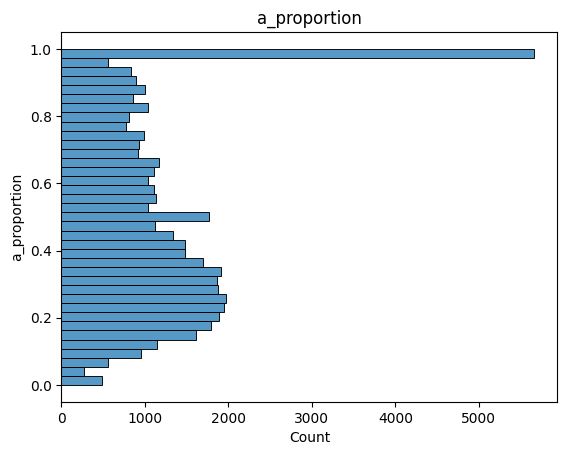

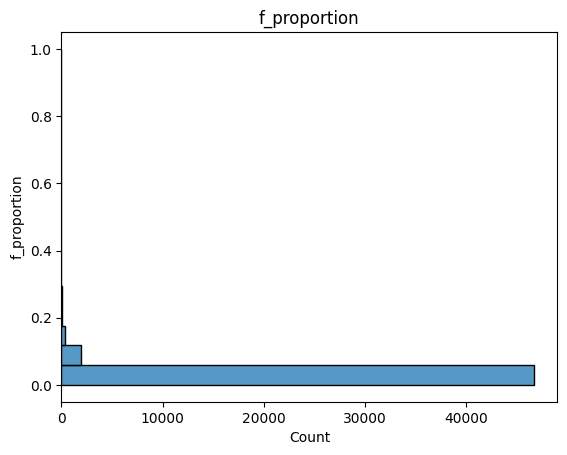

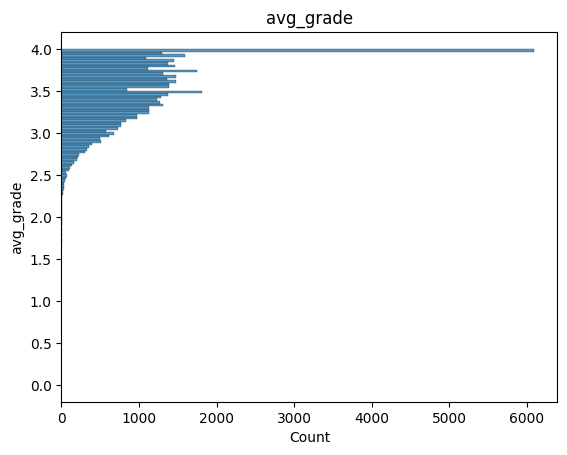

In [90]:
# three target variables
# make histograms and boxplots

targets = ['a_proportion', 'f_proportion', 'avg_grade']

for col in targets:
  col_name = col
  plot = sns.histplot(data = df, y = col)
  plot.set_title(col_name)
  plt.show()
  print('\n\n')

There is a very interesting distribution of As and Fs. The number of courses that have an a_proportion of 1, meaning that all students who received a letter grtade in that section received an A, is extremely high. This tells me that it may be difficult to predict it, since there may not be enough variation in the distribution to predict. It would be interesting to see if taking out the As would result in predicting more of the grade variation between B and F. 

The f_distribution shows what we would expect with the a_proportion, that since there are a lot of sections with an a_proportion of 1, there are equally as many sections with an f_proportion of 0. Again, taking Fs out to see if we can predict the remaining grade variation better would be interesting. 

The avg_grade, which is on a 4.0 grade-point scale, is skewed toward 4.0 with the number of sections with all As. It tapers down more or less until about a 2.25, after which there are not enough courses in those bins to see on the plot. A 2.0 is a C, which in my experience is the grade requirement to receive credit for a course (for a variety of reasons, such as it being a course in a major/minor). Although a D grade usually gives credit, there are many grade requirements that require a C. Given this information, it is interesting to see that a vast majority of courses have an average grade of above a 2.0, and definitely above a 1.0, meaning that the majority of students usually pass a course. 

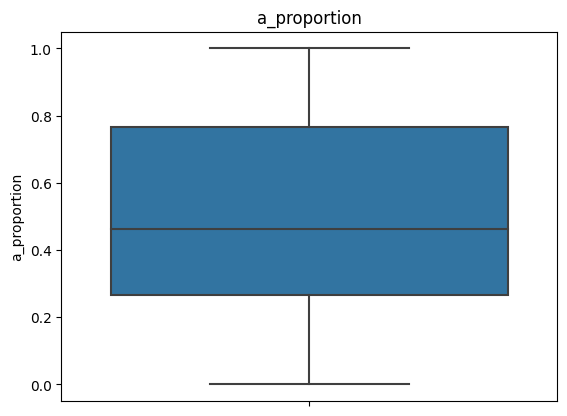

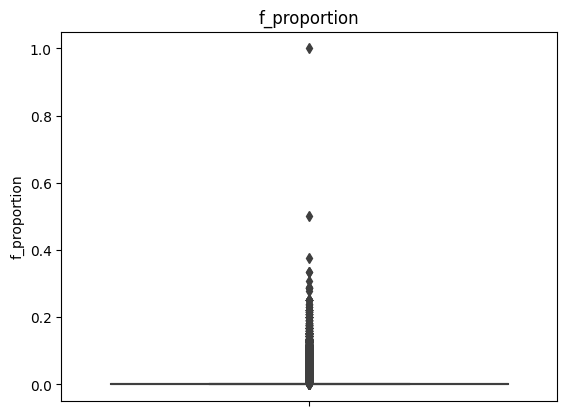

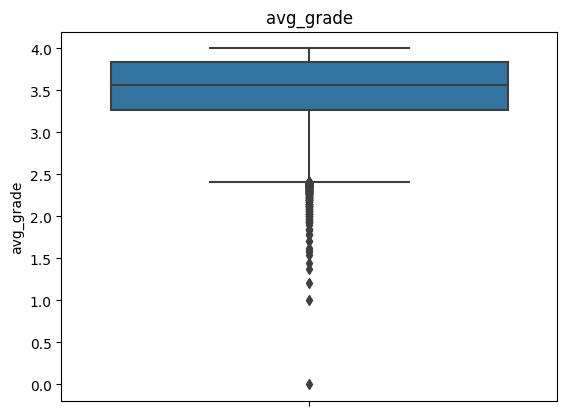

In [91]:
# boxplots for target variables to see outliers

targets = ['a_proportion', 'f_proportion', 'avg_grade']

for col in targets:
  col_name = col
  plot = sns.boxplot(data = df, y = col)
  plot.set_title(col_name)
  plt.show()
  print('\n\n')

The a_proportion boxplot shows us that most of the sections are centered around a median close to 0.5, meaning that out of all letter grades awarded, about have were As. 

The f_proportion boxplot shows us that by far most courses did not have any meaningful percentage of Fs, and the outlier course with the highest proportion of Fs had about 10% of the section awarded an F grade. 

The average grade boxplot shows us that most sections had a very high average grade, and only 20% of courses had an average grade of below about 2.5. There are several outlier sections with lower average grades, and one outlier section with an average grade of 0.0, which is an F.

In [92]:
df[df['avg_grade'] == 0]

,section_type,instructor_id,facility_code,start_time,mon,tues,wed,thurs,fri,subject_name,course_name,a_proportion,f_proportion,avg_grade,year,term,class_length,total_time,weekend,course_difficulty
39484,lab,2601912.0,0028,560.0,False,False,False,False,True,physical educ activity progm,adapted fitness&pers traing,0.0,1.0,0.0,08,fall,100.0,100,False,elementary


This is a very interesting case, but without more information suggesting it is not valid, I will keep it in the dataset for now. 

## Features

In [93]:
df.dtypes

section_type          object
instructor_id         object
facility_code         object
start_time           float64
mon                   object
tues                  object
wed                   object
thurs                 object
fri                   object
subject_name          object
course_name           object
a_proportion         float64
f_proportion         float64
avg_grade            float64
year                  object
term                  object
class_length         float64
total_time             int64
weekend               object
course_difficulty     object
dtype: object

In [96]:
all_features = ['section_type', 'instructor_id', 'facility_code', 'start_time',
            'mon', 'tues', 'wed', 'thurs', 'fri', 'weekend', 'subject_name',
            'course_name', 'year', 'term', 'class_length', 'total_time', 
            'course_difficulty']

In [ ]:
categorical_features = ['section_type', 'instructor_id', 'facility_code', 
                        'mon', 'tues', 'wed', 'thurs', 'fri', 'weekend', 
                        'subject_name', 'course_name', 'year', 'term',
                        'course_difficulty']

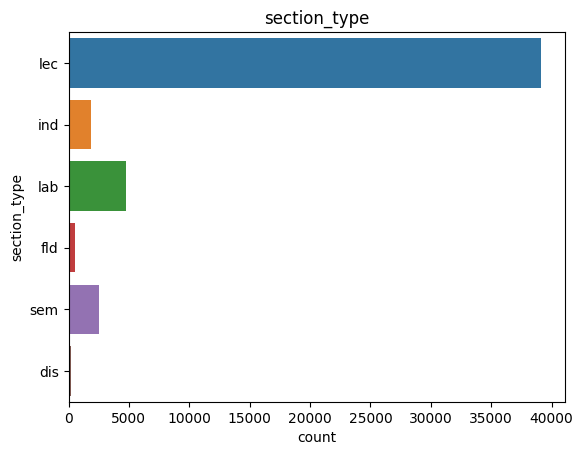

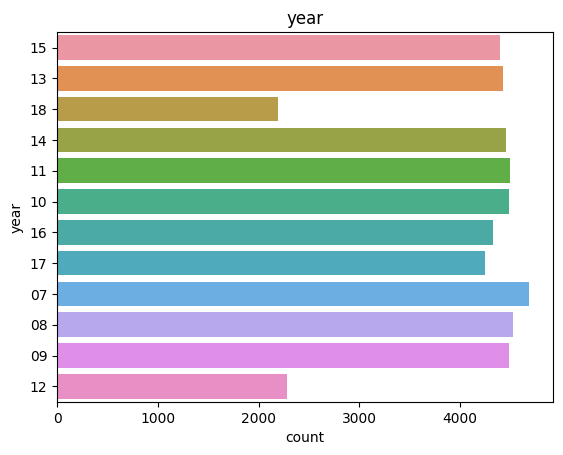

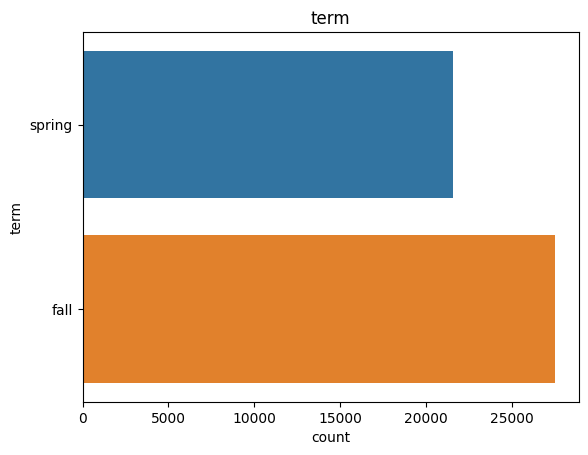

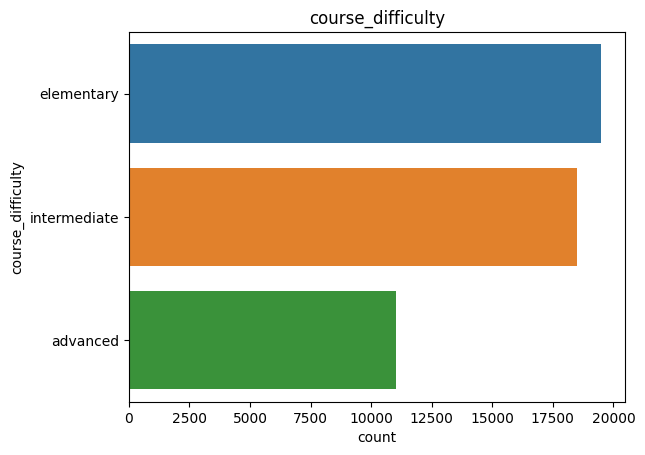

In [103]:
# barplots to explore categorical features except 'instructor_id', 'subject_
# name', 'course_name', and 'facility_code', which have too many distinct
# values to visualize cleanly

for col in ['section_type', 'year', 'term', 'course_difficulty']:
  col_name = col
  plot = sns.countplot(data = df, y = col)
  plot.set_title(col_name)
  plt.show()
  print('\n\n')

By far the most common section type is lecture. This is plausible; other section types are more specific and are reserved for non-typical classes. 

I'm not sure why the years 2012 and 2018 seem to have significantly fewer (almost by half) courses in the dataset compared to other years. This would be something to further investigate with the data originator. 

More courses are offered in Fall than Spring terms in general, so the breakdown by term looks normal. It is interesting that no Summer term courses are included in the dataset, and would be a very interesting addition. Students often wonder if they should take Summer courses, which are usually shorter in absolute duration, than semester-long classes. 

The distribution of course difficulty looks normal as well. Most courses are at the elementary/introductory level, then fewer students continue on to the intermediate then advanced courses, so there are fewer of those offered. 

In [ ]:
# visualize when courses meet
# count plot with mon-weekend as bars (true values)

In [ ]:
# good way to visualize 'instructor_id', 'course_name', 'subject_name', 'facility_code'?
# 'facility_code' = map of campus with key for facility_code numbers?
# subject_name = would probably have to group into departments, then could visualize with circle sizes; same with course_name

In [104]:
numeric_features = ['start_time', 'class_length', 'total_time']

# histograms, boxplots for start_time, class_length, total_time

In [111]:
df.describe(include = 'number')

,start_time,a_proportion,f_proportion,avg_grade,class_length,total_time
count,49012.000000,49012.000000,49012.000000,49012.000000,49012.000000,49012.000000
mean,676.647494,0.514208,0.008356,3.514628,74.034012,147.119073
std,241.312605,0.293018,0.023905,0.374382,48.227477,124.701743
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,570.000000,0.264706,0.000000,3.264706,50.000000,115.000000
50%,660.000000,0.461804,0.000000,3.559322,75.000000,150.000000
75%,865.000000,0.764706,0.000000,3.833333,75.000000,150.000000
max,1260.000000,1.000000,1.000000,4.000000,600.000000,3000.000000


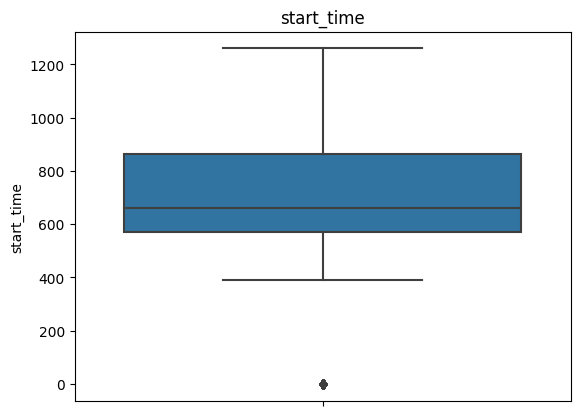

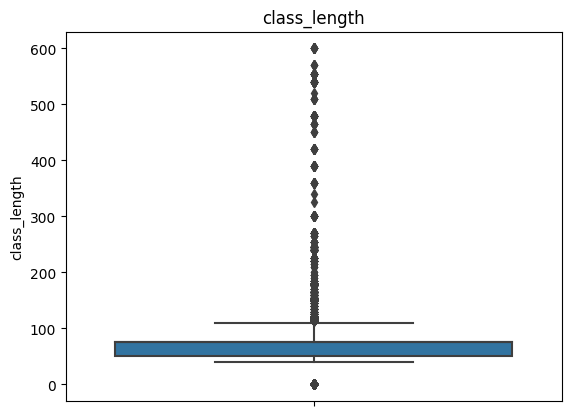

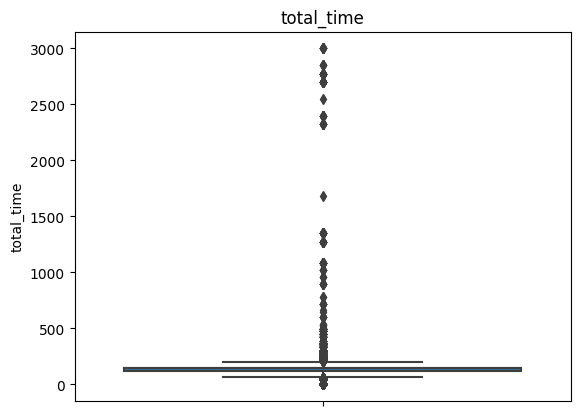

In [106]:
# boxplots for numeric variables to see outliers

for col in numeric_features:
  col_name = col
  plot = sns.boxplot(data = df, y = col)
  plot.set_title(col_name)
  plt.show()
  print('\n\n')

The outliers for 'start_time' that seem to be around 0 are the ones that don't have a start time assigned; they are coded in the original .csv files on Kaggle with the value -1.

Leaving out outliers for 'class_length' and 'total_time', the middle 50% of sections are between 50-75 minutes long and meet for a total of between 115-150 minutes per week. 



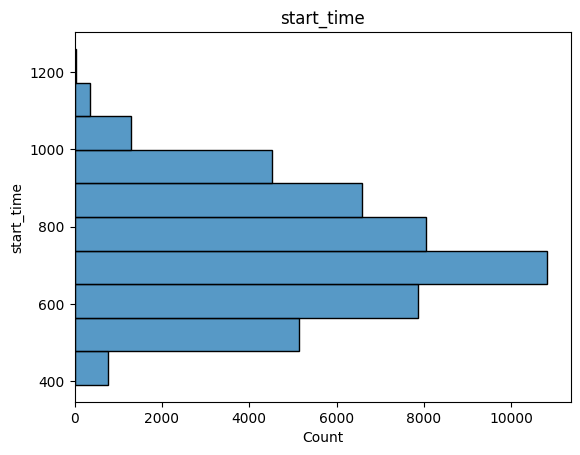

In [110]:
# histogram for start_time without outliers at -1
start_time_no_outliers_df = df[df['start_time'] != -1]

plot = sns.histplot(data = start_time_no_outliers_df, 
                    y = 'start_time',
                    bins = 10)
plot.set_title('start_time')
plt.show()

This histogram without outliers for start_time shows a relatively normal distribution centered around around 700 minutes (11 2/3 hours, so around noon). It makes sense that about half of classes start before noon and about half after. 

# Export to csv

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49012 entries, 12 to 64185
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   section_type       49012 non-null  object 
 1   instructor_id      49012 non-null  object 
 2   facility_code      45521 non-null  object 
 3   start_time         49012 non-null  float64
 4   mon                49012 non-null  object 
 5   tues               49012 non-null  object 
 6   wed                49012 non-null  object 
 7   thurs              49012 non-null  object 
 8   fri                49012 non-null  object 
 9   subject_name       49012 non-null  object 
 10  course_name        49012 non-null  object 
 11  a_proportion       49012 non-null  float64
 12  f_proportion       49012 non-null  float64
 13  avg_grade          49012 non-null  float64
 14  year               49012 non-null  object 
 15  term               49012 non-null  object 
 16  class_length       49

In [113]:
df.to_csv('/content/drive/MyDrive/Coding Dojo/Project 2/all_grades_data_cleaned.csv')